# Simple Stellar Population (SSP) Feedback with SYGMA

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from NuPyCEE import sygma
from NuPyCEE import omega
import fsps
import h5py

yield_dir = 'yield_tables/'

### Set parameters for SYGMA

In [2]:
# Parameter dictionary
params = dict()

# AGB and massive stars yields
params["table"] = yield_dir+'agb_and_massive_stars_K10_LC18_Ravg.txt'
params["imf_yields_range"] = [1.0, 100.0] # [Msun] - Stars in that mass range will eject metals

# Transition mass between AGB and massive star yields
# !!! --> CC SNe will be counted from the transition mass up to imf_yields_range[1]
params["transitionmass"] = 8.0 # [Msun]

# Type of IMF - can be a custom one
params["imf_type"] = 'chabrier'
params["imf_bdys"] = [0.1, 100] # [Msun] - Lower and upper limit of the IMF

# Mass of the stellar population [Msun]
params["mgal"] = 1.0

# SNe Ia
params["sn1a_table"] = yield_dir+'sn1a_i99_W7.txt'
params["nb_1a_per_m"] = 1.0e-3 # Number of SN Ia per units of Msun formed
params["sn1a_rate"] = 'power_law' # Shape (delay-time distribution) of the SN Ia rate
params["beta_pow"] = -1.0 # Slope of the power law (SN Ia rate)

# Neutron star mergers (NSMs)
params["ns_merger_on"] = True
params["nsmerger_table"] = yield_dir+'r_process_arnould_2007.txt' # r-process table (based on the solar composition)
params["nsm_dtd_power"] = [3.0e7, 1.0e10, -1.0] # Shape of the NSM rate, t^-1 from 30 Myr to 10 Gyr
params["nb_nsm_per_m"] = 1.5e-5 # Number of NSM per units of Msun formed
params["m_ej_nsm"] = 1.0e-2 # Mass ejected by each NSM 

# Timestep of the output
params["dt"] = 1.0e6
params["special_timesteps"] = 100 # Logarithmic timesteping
# See more timestep options here: 
# https://github.com/NuGrid/NuPyCEE/blob/master/DOC/Capabilities/Timesteps_size_management.ipynb

### Set parameters for FSPS
http://dfm.io/python-fsps/current/stellarpop_api/

In [3]:
# There should only ever be one StellarPopulation instance!
sp = fsps.StellarPopulation(zcontinuous=1, # specify single metallicity
                            sfh=0)         # compute an SSP; i.e., no SF hist
                                           # SF is always normalized to 1

In [4]:
sp.params['zred'] = 0.0

# IMF - can still be custom
sp.params['imf_type'] = 1 # Chabrier
sp.params['imf_lower_limit'] = params['imf_bdys'][0]
sp.params['imf_upper_limit'] = params['imf_bdys'][1]

# Major feature toggles
sp.params['add_neb_emission'] = False  # from Cloudy
sp.params['add_neb_continuum'] = False # off if neb emis is False
sp.params['nebemlineinspec'] = False   # incl emission fluxes in spectra

sp.params['add_agb_dust_model'] = True  # scaled by agb_dust
sp.params['add_dust_emission'] = False  # Draine & Li 2007; for CSPs
sp.params['cloudy_dust'] = False        # incl dust in Cloudy tables

sp.params['add_stellar_remnants'] = True # incl remnants in stellar mass calc

# Add stellar velocity dispersion or wavelength smoothing; default is none
sp.params['smooth_velocity'] = True # False smooths in wavelength space
sp.params['sigma_smooth'] = 0.0     # if smooth_velocity, dispersion in km/s

print('Isochrone & Spectral libraries:', sp.libraries,
      '(can only be changed by recompiling FSPS)')

Isochrone & Spectral libraries: (b'mist', b'miles', b'DL07') (can only be changed by recompiling FSPS)


### Extract the list of available metallicities

In [5]:
# Run a dummy chemical evolution calculation to access the table info
o_dummy = omega.omega(table=params["table"])
Z_table = o_dummy.Z_table[::-1]
nb_Z = len(Z_table)

# Print the metallicities
print("\nAvailable metallicities (Z, mass fraction)")
print("  ",Z_table)

OMEGA run in progress..
   OMEGA run completed - Run time: 0.24s

Available metallicities (Z, mass fraction)
   [3.236e-05, 0.0001, 0.0003236, 0.003236, 0.004, 0.008, 0.01345, 0.02]


### Run SYGMA for all available metallicities

In [6]:
sygma_instances = []
for Z in Z_table:
    sygma_instances.append(sygma.sygma(iniZ=Z, **params))

SYGMA run in progress..
   SYGMA run completed - Run time: 0.07s
SYGMA run in progress..
   SYGMA run completed - Run time: 0.07s
SYGMA run in progress..
   SYGMA run completed - Run time: 0.07s
SYGMA run in progress..
   SYGMA run completed - Run time: 0.07s
SYGMA run in progress..
   SYGMA run completed - Run time: 0.07s
SYGMA run in progress..
   SYGMA run completed - Run time: 0.07s
SYGMA run in progress..
   SYGMA run completed - Run time: 0.07s
SYGMA run in progress..
   SYGMA run completed - Run time: 0.07s


### Run FSPS for all available metallicities

In [7]:
fsps_outputs = []
Z_sol = 0.01295 # consistent with the grackle CLOUDY tables
for Z in Z_table:
    sp.params['logzsol'] = np.log10(Z/Z_sol)
    
wave, spec = sp.get_spectrum(peraa=True)

In [8]:
wave.shape, spec.shape, sp.log_age.shape

((5994,), (107, 5994), (107,))

Text(0, 0.5, 'log(sum(spectra))')

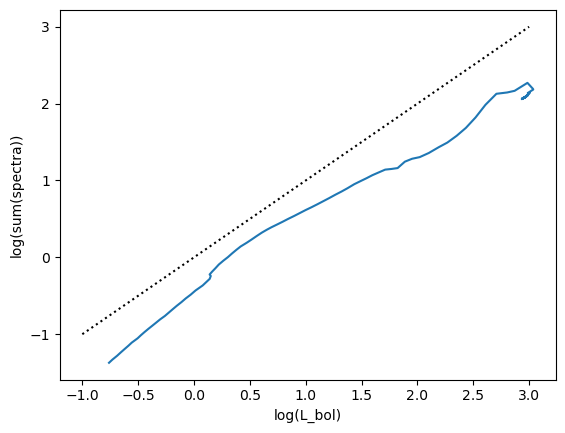

In [9]:
plt.plot(sp.log_lbol, np.log10(spec.sum(axis=1)))
plt.plot(np.linspace(-1,3), np.linspace(-1,3), 'k:')
plt.xlabel('log(L_bol)')
plt.ylabel('log(sum(spectra))')

### Create feedback table

In [10]:
source_indx = {"type2": 0,
               "type1a": 1,
               "agb": 2,
               "massive": 3}

nb_src = len(source_indx)

# Get the ages tracked by each SYGMA instance (i.e. each metallicity)
# Ensure they are all the same and are special_timesteps+1 in number
ages = np.array([inst.history.age for inst in sygma_instances])
assert np.isclose(ages, ages[0]).all()
assert np.all(ages.shape[1] == params["special_timesteps"]+1)
nb_dt = params["special_timesteps"]

met_key = np.zeros(nb_Z)
age_key = ages[0, :-1]

mass_table = np.zeros((nb_Z, nb_dt, nb_src))
metl_table = np.zeros_like(mass_table)
evnt_table = np.zeros((nb_Z, nb_dt, 2)) # just supernovae

for i_Z in range(nb_Z):

    model = sygma_instances[i_Z]
    met_key[i_Z] = model.iniZ
    hist = model.history

    # SYGMA histories use a mix of lists & numpy arrays
    ism_elem_yield_sn2 = [hist.ism_elem_yield[i] - 
                          (hist.ism_elem_yield_agb[i] +
                           hist.ism_elem_yield_1a[i]  +
                           hist.ism_elem_yield_massive[i])
                          for i in range(len(hist.ism_elem_yield))]
    
    ism_elem_yield_sn2[0][0] = 0 # this is erroneously set to 1 for some reason

    # Each set of ISM yields is time-integrated
    # Use NumPy to differentiate in order to keep data the same shape
    # (i.e., # ages by # elements, which is 81)
    # inst_yield_sn2     = np.gradient(ism_elem_yield_sn2, hist.age, axis=0)
    # inst_yield_sn1a    = np.gradient(hist.ism_elem_yield_1a, hist.age, axis=0)
    # inst_yield_agb     = np.gradient(hist.ism_elem_yield_agb, hist.age, axis=0)
    # inst_yield_massive = np.gradient(hist.ism_elem_yield_massive, hist.age, axis=0)

    # Each set of ISM yields is time-integrated
    # Manually differentiate so that we have nb_dt entries
    # (the first axis dimension matches the number of ages, which is nb_dt+1)
    # Division by the timestep (in yr) will happen after summing
    inst_yield_sn2     = np.diff(ism_elem_yield_sn2, axis=0)
    inst_yield_sn1a    = np.diff(hist.ism_elem_yield_1a, axis=0)
    inst_yield_agb     = np.diff(hist.ism_elem_yield_agb, axis=0)
    inst_yield_massive = np.diff(hist.ism_elem_yield_massive, axis=0)

    # The gradient goes negative at some parts near the highest ages so set these to 0
    inst_yield_sn2     = np.where(inst_yield_sn2 < 0, 0, inst_yield_sn2)
    inst_yield_sn1a    = np.where(inst_yield_sn1a < 0, 0, inst_yield_sn1a)
    inst_yield_agb     = np.where(inst_yield_agb < 0, 0, inst_yield_agb)
    inst_yield_massive = np.where(inst_yield_massive < 0, 0, inst_yield_massive)

    # Collect mass injected by each source (i.e. sum over all elements)
    mass_table[i_Z, :, source_indx["type2"]]   = inst_yield_sn2.sum(axis=1) / hist.timesteps 
    mass_table[i_Z, :, source_indx["type1a"]]  = inst_yield_sn1a.sum(axis=1) / hist.timesteps
    mass_table[i_Z, :, source_indx["agb"]]     = inst_yield_agb.sum(axis=1) / hist.timesteps
    mass_table[i_Z, :, source_indx["massive"]] = inst_yield_massive.sum(axis=1) / hist.timesteps

    # Collect metal mass injected by each source
    # (i.e. sum over all metal elements)
    metl_table[i_Z, :, source_indx["type2"]]   = inst_yield_sn2[:, 4:].sum(axis=1) / hist.timesteps
    metl_table[i_Z, :, source_indx["type1a"]]  = inst_yield_sn1a[:, 4:].sum(axis=1) / hist.timesteps
    metl_table[i_Z, :, source_indx["agb"]]     = inst_yield_agb[:, 4:].sum(axis=1) / hist.timesteps
    metl_table[i_Z, :, source_indx["massive"]] = inst_yield_massive[:, 4:].sum(axis=1) / hist.timesteps

    # Number of SNe per year
    evnt_table[i_Z, :, source_indx["type2"]]  = model.sn2_numbers / hist.timesteps
    evnt_table[i_Z, :, source_indx["type1a"]] = model.sn1a_numbers / hist.timesteps

# Set all nan to zero (because there was no total mass in those cells)
np.nan_to_num(metl_table, copy=False) # in-place

# Perform final checks & unit conversions
assert (mass_table >= 0).all()
assert (metl_table >= 0).all()
assert (evnt_table >= 0).all()

# Convert rates to per second?

/tmp/ipykernel_18024/614321951.py:78: RuntimeWarning: invalid value encountered in divide
  metl_table /= mass_table


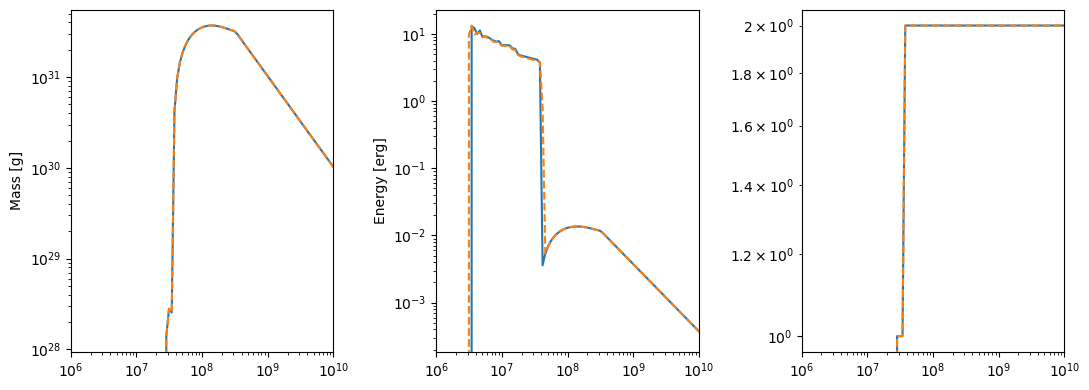

In [11]:
length_units = 1.2344e+21 # cm
mass_units = 1.0e-24 * length_units**3 # g 
time_units = 3.154e16 # sec
g_per_msun = 1.988e33
sec_per_yr = 3.1557e7

dt = 0.9 
dt *= time_units/sec_per_yr

fig, ax = plt.subplots(ncols=3, sharex=True, figsize=(11,4))

ax[0].loglog(age_key, 
             (mass_table[4, :, source_indx["type2"]]+mass_table[4, :, source_indx["type1a"]])*g_per_msun\
             * 20*dt,
             label=f"Z={met_key[4]}")
ax[0].loglog(age_key, 
             (mass_table[5, :, source_indx["type2"]]+mass_table[5, :, source_indx["type1a"]])*g_per_msun\
             * 20*dt,
             label=f"Z={met_key[5]}", ls = '--')
ax[0].set_ylabel("Mass [g]")

ax[1].loglog(age_key, 
             (evnt_table[4, :, source_indx["type2"]]+evnt_table[4, :, source_indx["type1a"]])\
             * 20*dt,
             label=f"Z={met_key[4]}")
ax[1].loglog(age_key, 
             (evnt_table[5, :, source_indx["type2"]]+evnt_table[5, :, source_indx["type1a"]])\
             * 20*dt,
             label=f"Z={met_key[5]}", ls = '--')
ax[1].set_ylabel("N Events")

ax[2].loglog(age_key, 
             (metl_table[4, :, source_indx["type2"]]+metl_table[4, :, source_indx["type1a"]]),
             #* 20*dt,
             label=f"Z={met_key[4]}")
ax[2].loglog(age_key, 
             (metl_table[5, :, source_indx["type2"]]+metl_table[5, :, source_indx["type1a"]]),
             #* 20*dt,
             label=f"Z={met_key[5]}", ls = '--')
ax[1].set_ylabel("Energy [erg]")

ax[0].set_xlim(1e6,1e10)

fig.tight_layout()

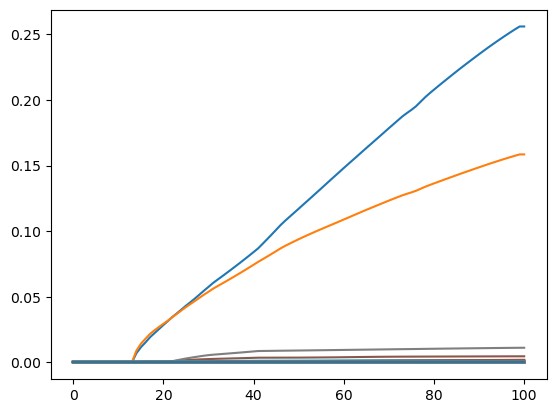

In [12]:
yields = np.array(hist.ism_elem_yield)
yields[0,0]=0
plt.plot(yields)

In [13]:
np.sum(yields, axis=1)

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.01666087,
       0.026803  , 0.03439394, 0.04209814, 0.0482608 , 0.05399589,
       0.05977416, 0.0654395 , 0.07230723, 0.07898662, 0.085791  ,
       0.09243377, 0.09853022, 0.10471919, 0.11099835, 0.11726866,
       0.12308974, 0.12899388, 0.1340204 , 0.13896446, 0.14397937,
       0.14906587, 0.15422467, 0.1594565 , 0.16476204, 0.17014199,
       0.17559743, 0.18112926, 0.18673811, 0.19242462, 0.19818938,
       0.20403298, 0.20995594, 0.21521522, 0.22011476, 0.22497945,
       0.22981294, 0.23464968, 0.23937912, 0.24413668, 0.24886532,
       0.25356103, 0.25829517, 0.26301871, 0.26767902, 0.27238074,
       0.27712383, 0.28180423, 0.28645564, 0.29112744, 0.29581777,
       0.30047962, 0.3050442 , 0.3096153 , 0.31419116, 0.31876992,
       0.32334962, 0.32781745, 0.33227258, 0.33671638, 0.34049

Per solar mass of initial population, 0.439 solar masses are yielded in total. This means the total yield can be expressed as a fraction (here, 0.439) and the total mass is (total mass fraction) * (initial population mass). Likewise, the source masses are (source mass fraction) * (initial population mass).

For the SNe, 100% of the yielded mass fraction is metals. This means the yield of metals from, e.g., a Type II SNe is (source metal fraction) * (source mass fraction) * (initial population mass). The metal fractions of each source cannot be directly summed; the total metal mass must first be found and then the total mass fraction derived from that.

Of course, what's actually in the table is a bunch of **rates**. But the same logic applies; only a factor of dt is needed at the end.